# GNN on spatial AR process

The main purpose of this notebook is to explore the ability of a Graph Recurrent Neural Network to predict on a spatial auto-regressive process. We begin by implementing a simple model where data are generated on a ring-like graph with an AR(1) spatial lag and an AR(1) temporal lag process. We will implement fitting by splitting the time-series into chunks of a specified sequence length and pass through a GRNN with three layers: a graph convolutional layer, a LSTM layer, and another graph convolutional layer. In the final layer the last point in the time-series is extracted for the h-step ahead prediction.


torch==1.9.0
torch_geometric==1.7.2
networkx==2.6.2
matplotlib==3.4.3
numpy==1.21.2
pandas==1.3.3
pyyaml==5.4.1

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np




## GNN on spatial AR process


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [3]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.gcn2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.reshape(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.reshape(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().reshape(batch_size * num_timesteps, -1)
        x = self.gcn2(x, edge_index)
        x = x.reshape(batch_size, num_timesteps, -1)
        x = x[:,-1,:]
        # get final time-point in time-series
        
        return x

In [23]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

num_nodes = 10
num_timesteps = 100
noise_scale = 0.05
rhos = [0.5,0.1,0.1]
# Simulate more structured traffic data: 10 nodes (e.g., sensors) with 100 time steps

def generate_spatial_ar_process(
    num_nodes = 10,
    num_timesteps = 100,
    rhos = [0.5,0.1,0.2],
    noise_scale = 0.1):
    """generate spatial AR process on a ring network

    Parameters
    ----------
    num_nodes : int, optional
        number of network nodes, by default 10
    num_timesteps : int, optional
        number of time steps for time-series, by default 100
    rhos : list, optional
        auto-regressive terms for self, past node and next node, by default [0.5,0.1,0.2]
    noise_scale : float, optional
        noise process standard deviation, by default 0.1

    Returns
    -------
    array
        time-series of shape (num_nodes,num_timesteps)
    """    
    # Generate time series data with a pattern
    time_series_data = np.zeros((num_timesteps,num_nodes))
    inits = np.random.normal(loc=0.0,scale=noise_scale, size=num_nodes)
    time_series_data[0,:] = inits
    for t in range(1,num_timesteps):
        # assuming a ring graph where each node is dependent on previous and next node modulo number of nodes
        time_series_data[t,:] = rhos[0]*time_series_data[t-1,:] +\
            rhos[1]*np.roll(time_series_data[t-1,:],shift=1) +\
            rhos[2]*np.roll(time_series_data[t-1,:],shift=-1) +\
            np.random.normal(loc=0., scale = noise_scale, size=num_nodes)

    return time_series_data

time_series_data = generate_spatial_ar_process(rhos = rhos,
                                               num_nodes=num_nodes,
                                               num_timesteps=num_timesteps,
                                               noise_scale=noise_scale)

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
data = Data(x=x, edge_index=edge_index)

# y is just a copy of x for now 
# will do one step ahead prediction in the training step 
data.y = time_series_data#np.roll(time_series_data,shift=1,axis=0)
data.y[0,:] = np.zeros(num_nodes)
data.y = np.swapaxes(data.y,0,1)
data.y = data.y[:,:,np.newaxis]
data.y = torch.tensor(data.y,dtype=torch.float)

In [24]:
print(data.y.shape)
print(data.x.shape)

torch.Size([10, 100, 1])
torch.Size([10, 100, 1])


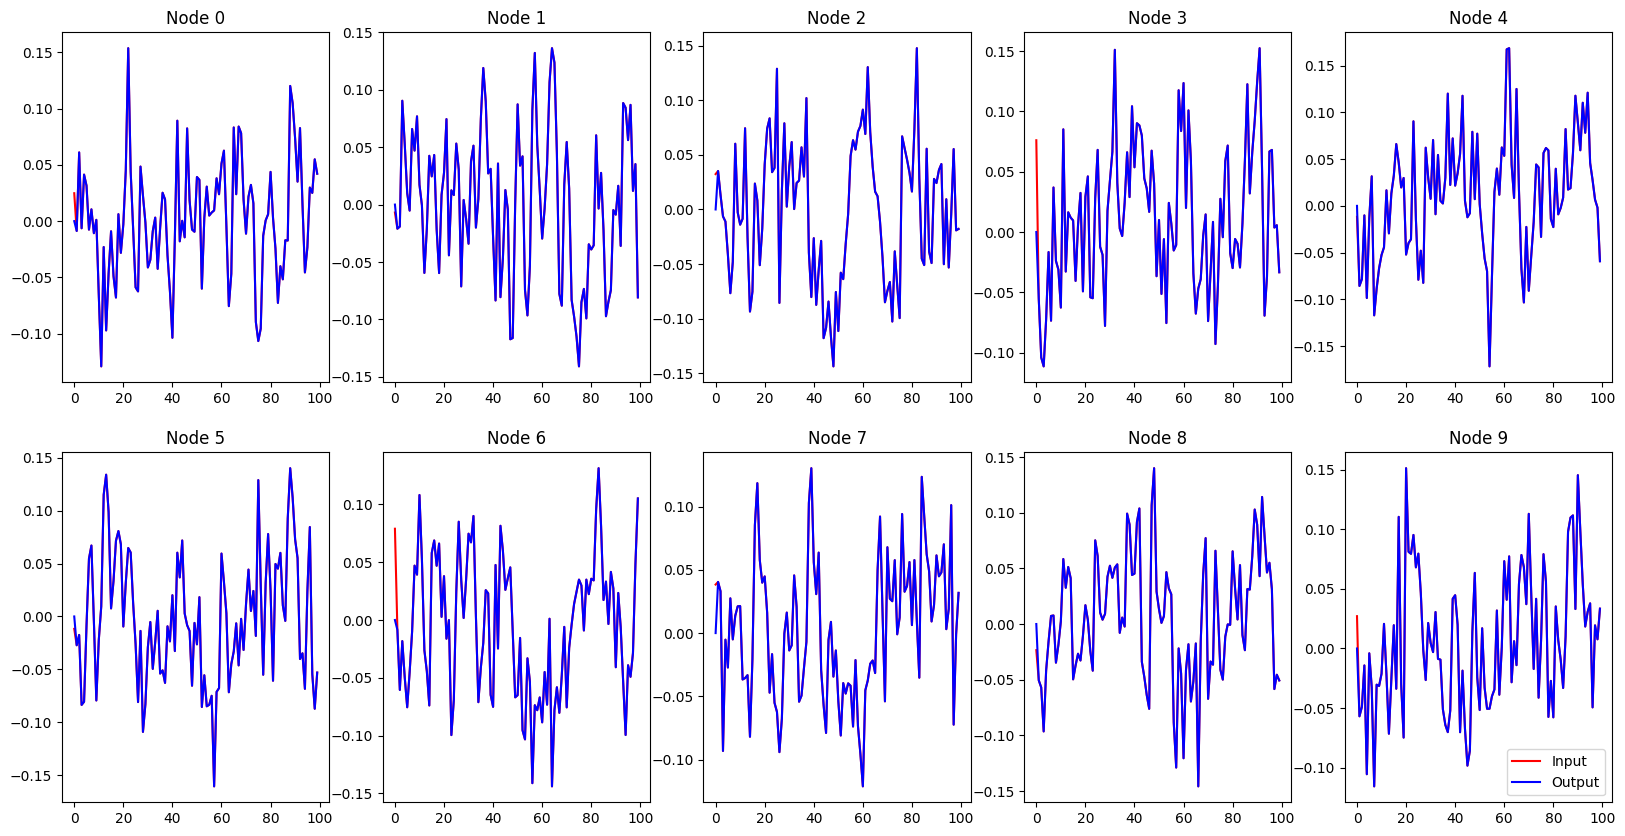

In [25]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.x[i,:,0],color="red",label="Input")
    plt.plot(data.y[i,:,0],color="blue",label="Output")
    plt.title(f'Node {i}')
plt.legend()
plt.show()

Epoch 0, Loss: 0.004518930334597826
Epoch 5, Loss: 0.005711705889552832
Epoch 10, Loss: 0.005607905797660351
Epoch 15, Loss: 0.0053357756696641445
Epoch 20, Loss: 0.005596082657575607
Epoch 25, Loss: 0.005652973894029856
Epoch 30, Loss: 0.005688592791557312
Epoch 35, Loss: 0.0057096281088888645
Epoch 40, Loss: 0.005731047131121159
Epoch 45, Loss: 0.005737884435802698


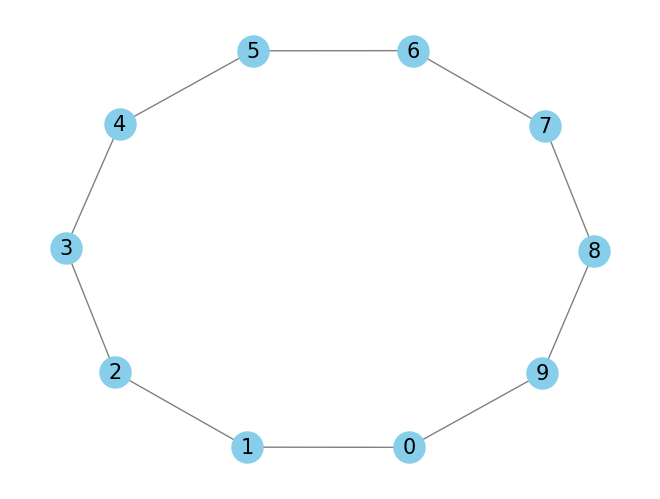

In [33]:
# Initialize the model
num_nodes = 10
num_timesteps = 100
input_dim = 1
hidden_dim = 32
output_dim = 1
# length of time-series sequence to include
seq_length = 7
# number of steps ahead for prediction
h_step = 1
# number of epochs
num_epochs = 50
model = TemporalGNN(num_nodes, seq_length, input_dim, hidden_dim, output_dim)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# save final output in last epoch
model_fit = np.zeros((num_nodes,num_timesteps))
# Training loop
model.train()
for epoch in range(num_epochs):
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        optimizer.zero_grad()
        out = model(chunk_data)
        loss = criterion(out, data.y[:,i+seq_length+h_step,:])
        loss.backward()
        optimizer.step()
        if epoch == (num_epochs - 1):
            model_fit[:,i+seq_length+h_step] = out[:, 0].detach().numpy()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(edge_index, num_nodes)

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

In [34]:
print(model)

TemporalGNN(
  (gcn1): GCNConv(1, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (gcn2): GCNConv(32, 1)
)


In [35]:
out.shape

torch.Size([10, 1])

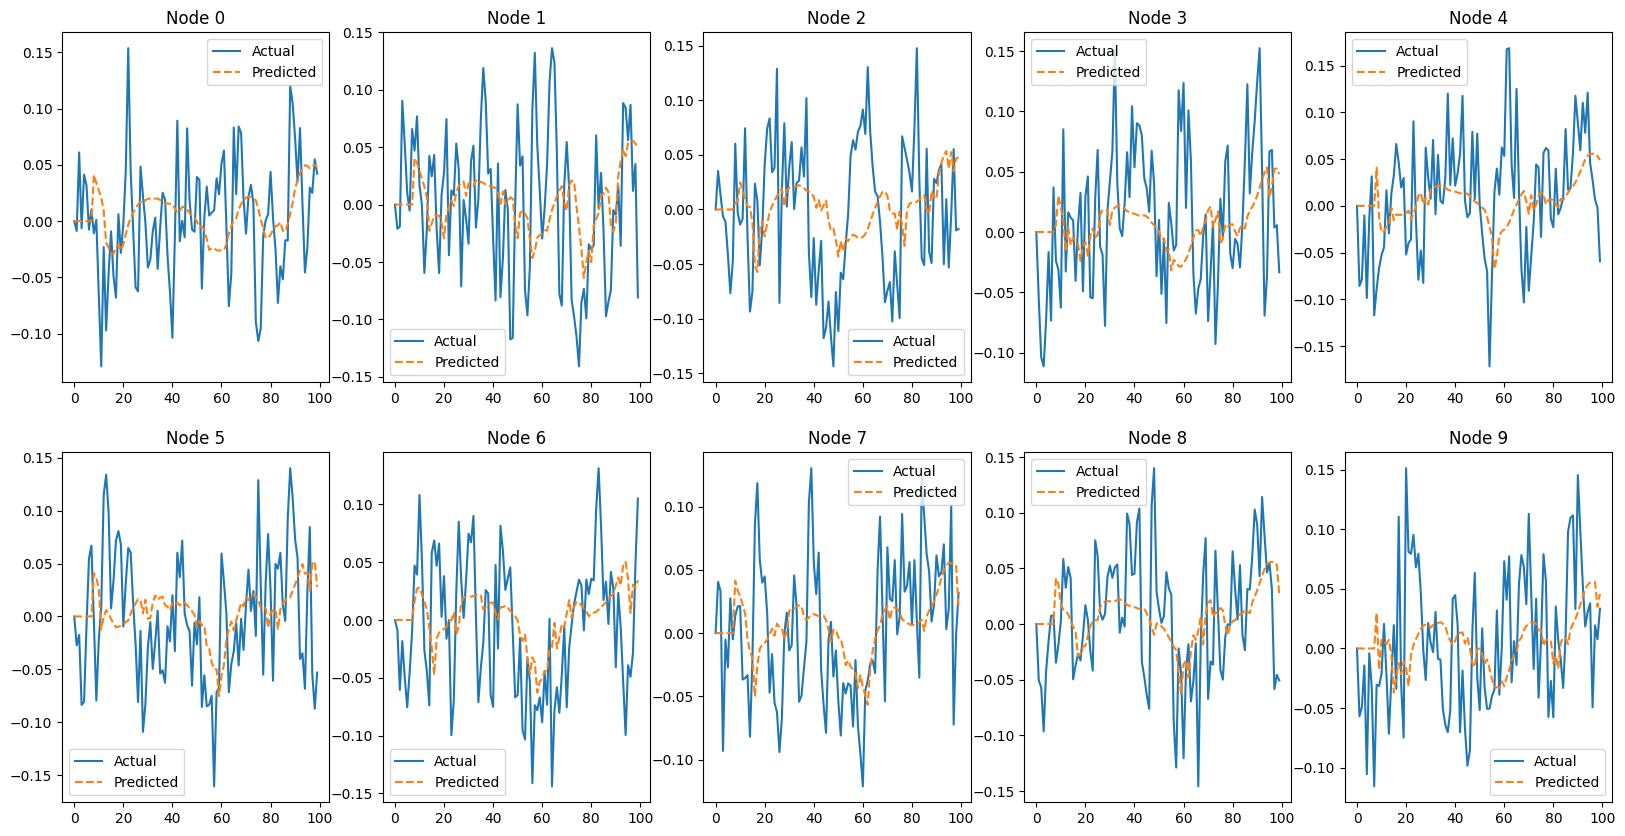

In [36]:

# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(model_fit[i,:], linestyle = "--", label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

In [37]:
# Set random seed for reproducibility
np.random.seed(4995)
torch.manual_seed(4995)

time_series_data = generate_spatial_ar_process(rhos = rhos,
                                               num_nodes=num_nodes,
                                               num_timesteps=num_timesteps,
                                               noise_scale=noise_scale)

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
val_data = Data(x=x, edge_index=edge_index)

# one step ahead prediction
val_data.y = np.roll(time_series_data,shift=1,axis=0)
val_data.y[0,:] = np.zeros(num_nodes)
val_data.y = np.swapaxes(val_data.y,0,1)
val_data.y = val_data.y[:,:,np.newaxis]
val_data.y = torch.tensor(val_data.y,dtype=torch.float)

# generate new embeddings
# Get the final node embeddings
model_val = np.zeros((num_nodes,num_timesteps))
model.eval()
with torch.no_grad():
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = val_data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        out = model(chunk_data)
        model_val[:,i+seq_length+h_step] = out[:, 0].detach().numpy()

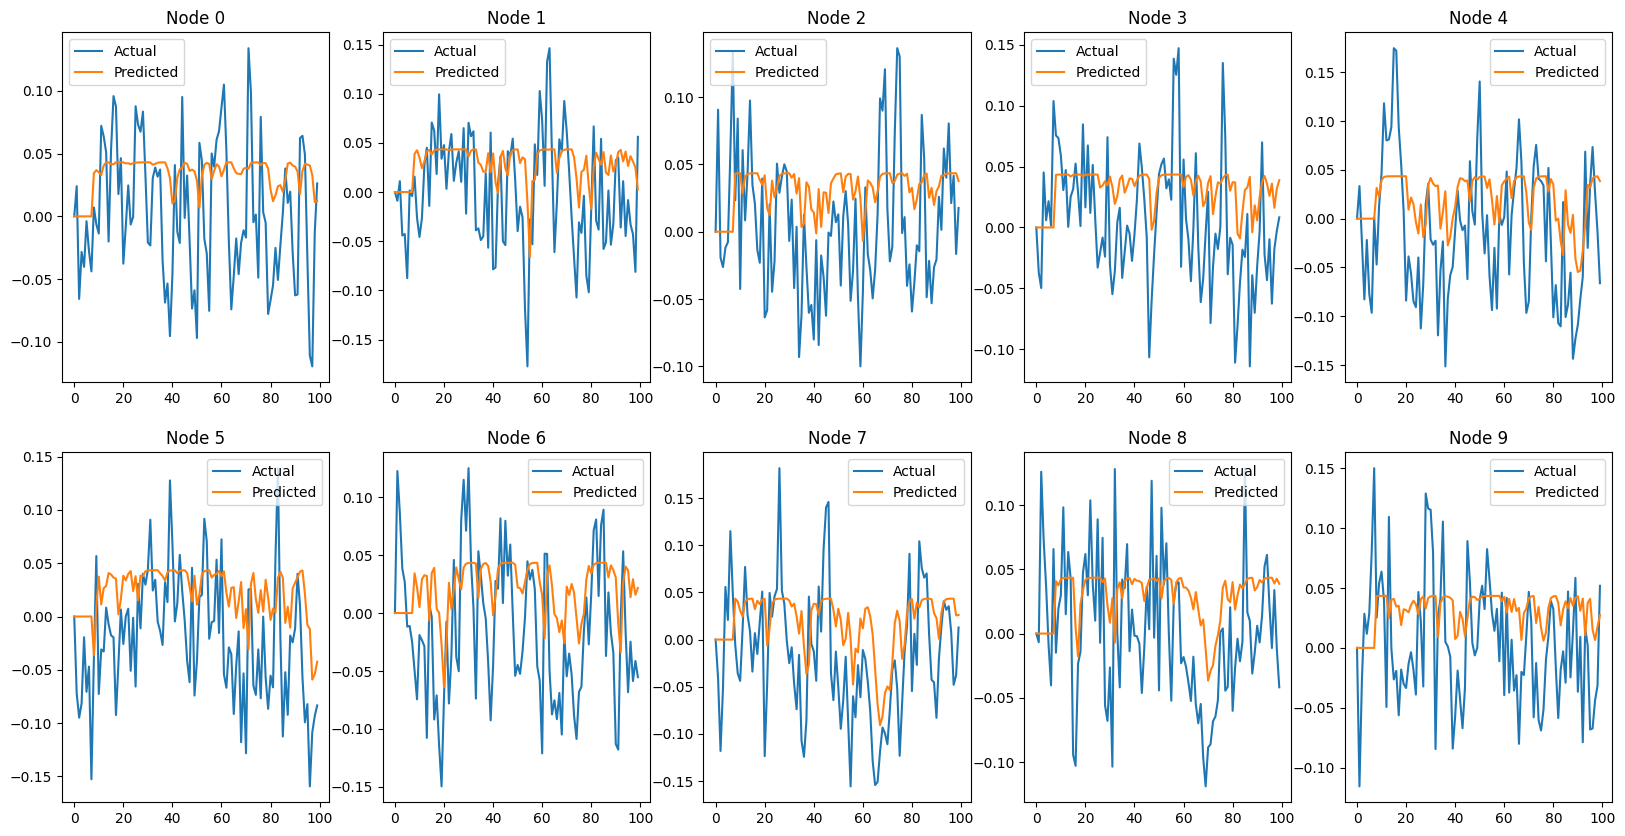

In [38]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(val_data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(model_val[i, :], label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()